In [1]:
from scipy.io import loadmat
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
pd.plotting.register_matplotlib_converters()
%matplotlib notebook

In [2]:
# Import GLODAP dataset as a standard pandas DataFrame
df = loadmat('datasets/GLODAPv2.2020_Atlantic_Ocean.mat')
df = {
    k[2:]: v.ravel()
    for k, v in df.items()
    if k.startswith('G2')
}
df = pd.DataFrame(df)

# Get tables of unique stations and cruises
stations = (
    df[['cruise', 'station', 'latitude', 'longitude']]
    .groupby(['cruise', 'station'])
    .agg('mean')
)
cruises = df.cruise.unique()
# ^a few interesting ones: cruises[[0, 30, **47**, 48, 50, 75, 100]]

# Also get GeoDataFrame
gstations = gpd.GeoDataFrame(
    stations, geometry=gpd.points_from_xy(stations.longitude, stations.latitude))

<IPython.core.display.Javascript object>


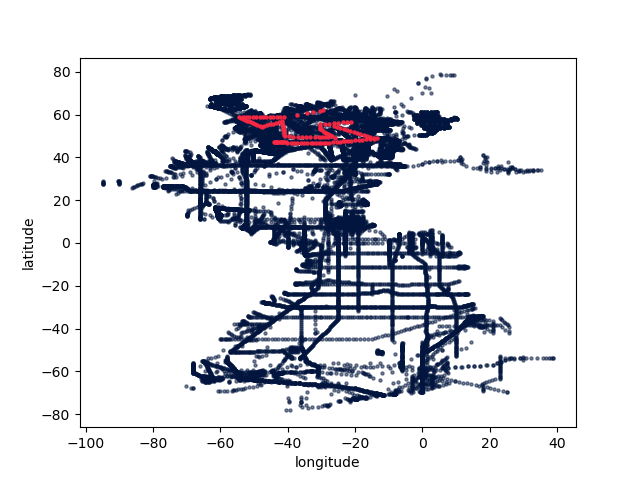

In [3]:
# Plot cruises, highlighting one of them
fig, ax = plt.subplots()
stations.plot.scatter('longitude', 'latitude', c='xkcd:navy', s=5, alpha=0.5, ax=ax)
stations.loc[cruises[47]].plot.scatter('longitude', 'latitude', s=5, alpha=0.9, c='xkcd:strawberry', ax=ax)

<IPython.core.display.Javascript object>


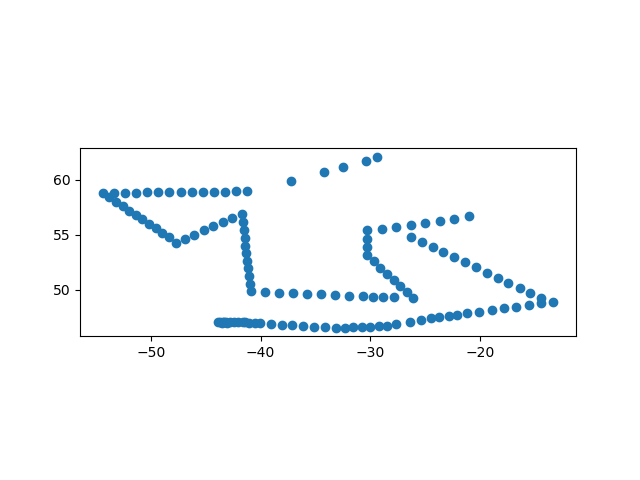

In [4]:
# Just get the cruise of interest now as a GeoDataFrame
cruise_of_interest = cruises[47]
gstations.loc[cruise_of_interest].plot()

In [7]:
dataset = gstations.loc[cruise_of_interest]
dataset

,latitude,longitude,geometry
station,,,
449.0,62.090,-29.424,POINT (-29.42400 62.09000)
450.0,61.758,-30.435,POINT (-30.43500 61.75800)
451.0,61.183,-32.483,POINT (-32.48300 61.18300)
452.0,60.701,-34.242,POINT (-34.24200 60.70100)
453.0,59.874,-37.195,POINT (-37.19500 59.87400)
...,...,...,...
585.0,47.000,-43.334,POINT (-43.33400 47.00000)
586.0,47.001,-43.406,POINT (-43.40600 47.00100)
587.0,46.999,-43.507,POINT (-43.50700 46.99900)
